# Capstone Project: Topic Modelling of Academic Journals (Model-Based Systems Engineering)

# 02: Preprocessing and EDA

In this notebook, we will perform the following actions:
1. Data preprocessing
2. Exploratory Data Analysis (EDA)

## Import Libraries

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import re

# Set all columns and rows to be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Import Data

In [80]:
# Import journals data
journals = pd.read_csv('../data/journals.csv')

In [81]:
# Take a look at the dataframe
journals.head()

,title,abstract,year
0,Model-based Design Process for the Early Phase...,This paper presents an approach for a model-ba...,2017
1,Model Based Systems Engineering using VHDL-AMS,The purpose of this paper is to contribute to ...,2013
2,Code Generation Approach Supporting Complex Sy...,Code generation is an effective way to drive t...,2022
3,Model based systems engineering as enabler for...,"Product complexity is steadily increasing, cus...",2021
4,Electric Drive Vehicle Development and Evaluat...,To reduce development time and introduce techn...,2014


In [82]:
# Check the shape of the data
journals.shape

(850, 3)

## Data Dictionary

In [83]:
# Check the columns in the dataframe
journals.columns

Index(['title', 'abstract', 'year'], dtype='object')

Columns in the dataframe

|Column Name | Use of Column|
|------------|--------------|
|title| Title of the academic journal. Through topic modelling, each title will be assigned to a topic for quick search later on|
|abstract| Abstract of each academic journal. This data will be preprocessed and used as the dataset for the unsupervised learning to identify topics|
|year| Year that the academic journal was published. This will be used to identify shifts in trends between the topics over the years|

## Data Preprocessing

In this section, we will process the text data in the abstract column by cleaning the text, tokenizing and lemmatizing them. A description in more detail is provided below.
* Cleaning the text to remove special characters
* Tokenizing (converts sentences into individual words, and by using ngrams, we can also form tokens with multiple words to give better context)
* Lemmatization (converts different words with the same meaning/intent into the same word)
* Stop word removal (stop words are filler words that do not provide any context and just assist with sentence structure)

### Definition of Stopwords

We will assign the stopwords from NLTK to a list called stop_words. This is so that the list can be further expanded later on when looking at the word frequency.

In [84]:
stop_words = stopwords.words('english')

### Function Defintion for Preprocessing

The below function will be used to preprocess the text data by perform the functions listed above. 

In [85]:
def preprocess_text(text):
    
    # Remove 's
    text = re.sub(r"'s", '', text)
    
    # Remove n't (example don't)
    text = re.sub(r"n't", '', text)
    
    # Remove 'm (example I'm)
    text = re.sub(r"'m", '', text)
    
    # Remove 'd (e.g. I'd)
    text = re.sub(r"'d", '', text)
    
    # Remove 're (example They're)
    text = re.sub(r"'re", '', text)
    
    # Remove 've (example They've)
    text = re.sub(r"'ve", " have", text)
    
    # Remove 'll (example We'll)
    text = re.sub(r"'ll", '', text)
    
    # Remove URL links
    text = re.sub(r'http\S+', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Change all text to lower case
    text = text.lower()
    
    # Remove the word abstract as it was included as the first word in one of the dataset
    text = re.sub(r"abstract", '', text)
    
    # Tokenize the text
    text = word_tokenize(text)
    
    # Lemmatize the text
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(i) for i in text]
    
    # Remove stop words
    text = [token for token in text if token not in stop_words]
    
    return text

### Preprocess the Text Data

Here, we will apply the preprocess_text function to clean and tokenize our text data

In [86]:
%%time
# Place the proprocessed data as a new column called tokens
journals['tokens'] = journals['abstract'].apply(preprocess_text)

CPU times: user 1.74 s, sys: 41.4 ms, total: 1.79 s
Wall time: 2.12 s


In [87]:
# Check the tokens
journals['tokens'].head()

0    [paper, present, approach, model-based, planni...
1    [purpose, paper, contribute, definition, model...
2    [code, generation, effective, way, drive, comp...
3    [product, complexity, steadily, increasing, ,,...
4    [reduce, development, time, introduce, technol...
Name: tokens, dtype: object

### Vectorize the words for EDA

We will use CountVectorizer to vectorize our words, to enable EDA.

In [88]:
# Join the tokenized words so that we can vectorize them
journals['tokens'] = [" ".join(post) for post in journals['tokens']]

In [89]:
# Instantiate a CountVectorizer with ngrams 1 for word frequency analysis
cvec_journals_1 = CountVectorizer(lowercase=False, ngram_range=(1,1))

In [90]:
# Fit the Count Vectorizer, transform the data and export them into a dataframe

# Unigrams
cvec_journals_1.fit(journals['tokens'])
journals_unigrams = cvec_journals_1.transform(journals['tokens'])
journals_unigrams = pd.DataFrame(journals_unigrams.todense(), 
                                 columns=cvec_journals_1.get_feature_names_out())

## Exploratory Data Analysis (EDA)

In this section, we'll conduct EDA to look at the distribution of the text as well as most frequently occuring words. Furthermore, based on the EDA, we will further clean the text.

#### Document Length Distribution

In [91]:
# Initialize a dataframe to store the additional EDA data
eda_journals = pd.DataFrame()

In [92]:
# Calculate the word count for the abstracts
eda_journals['word_count'] = journals['tokens'].map(lambda x: len(x.split()))

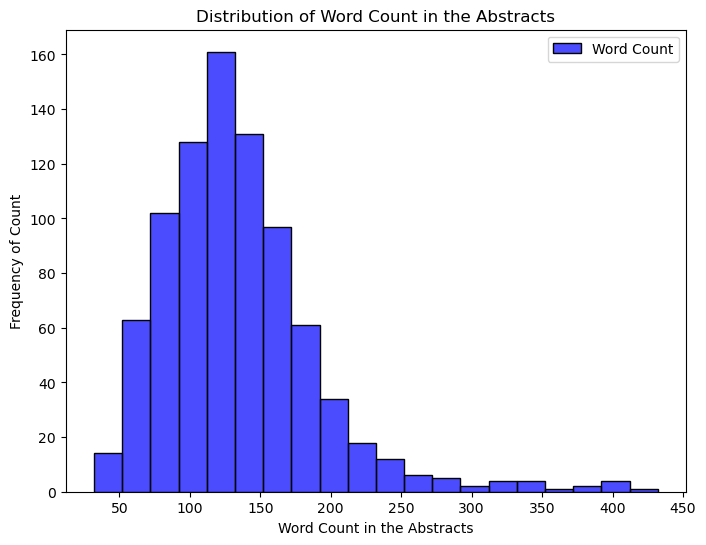

In [93]:
# Create a histogram plot to view the distribution of the word count in the abstracts
plt.figure(figsize=(8, 6))
sns.histplot(eda_journals['word_count'], kde=False, bins=20, label="Word Count", 
             color="blue", alpha = 0.7)

plt.title("Distribution of Word Count in the Abstracts")
plt.xlabel("Word Count in the Abstracts")
plt.ylabel("Frequency of Count")
plt.legend();

#### Word Frequency Analysis

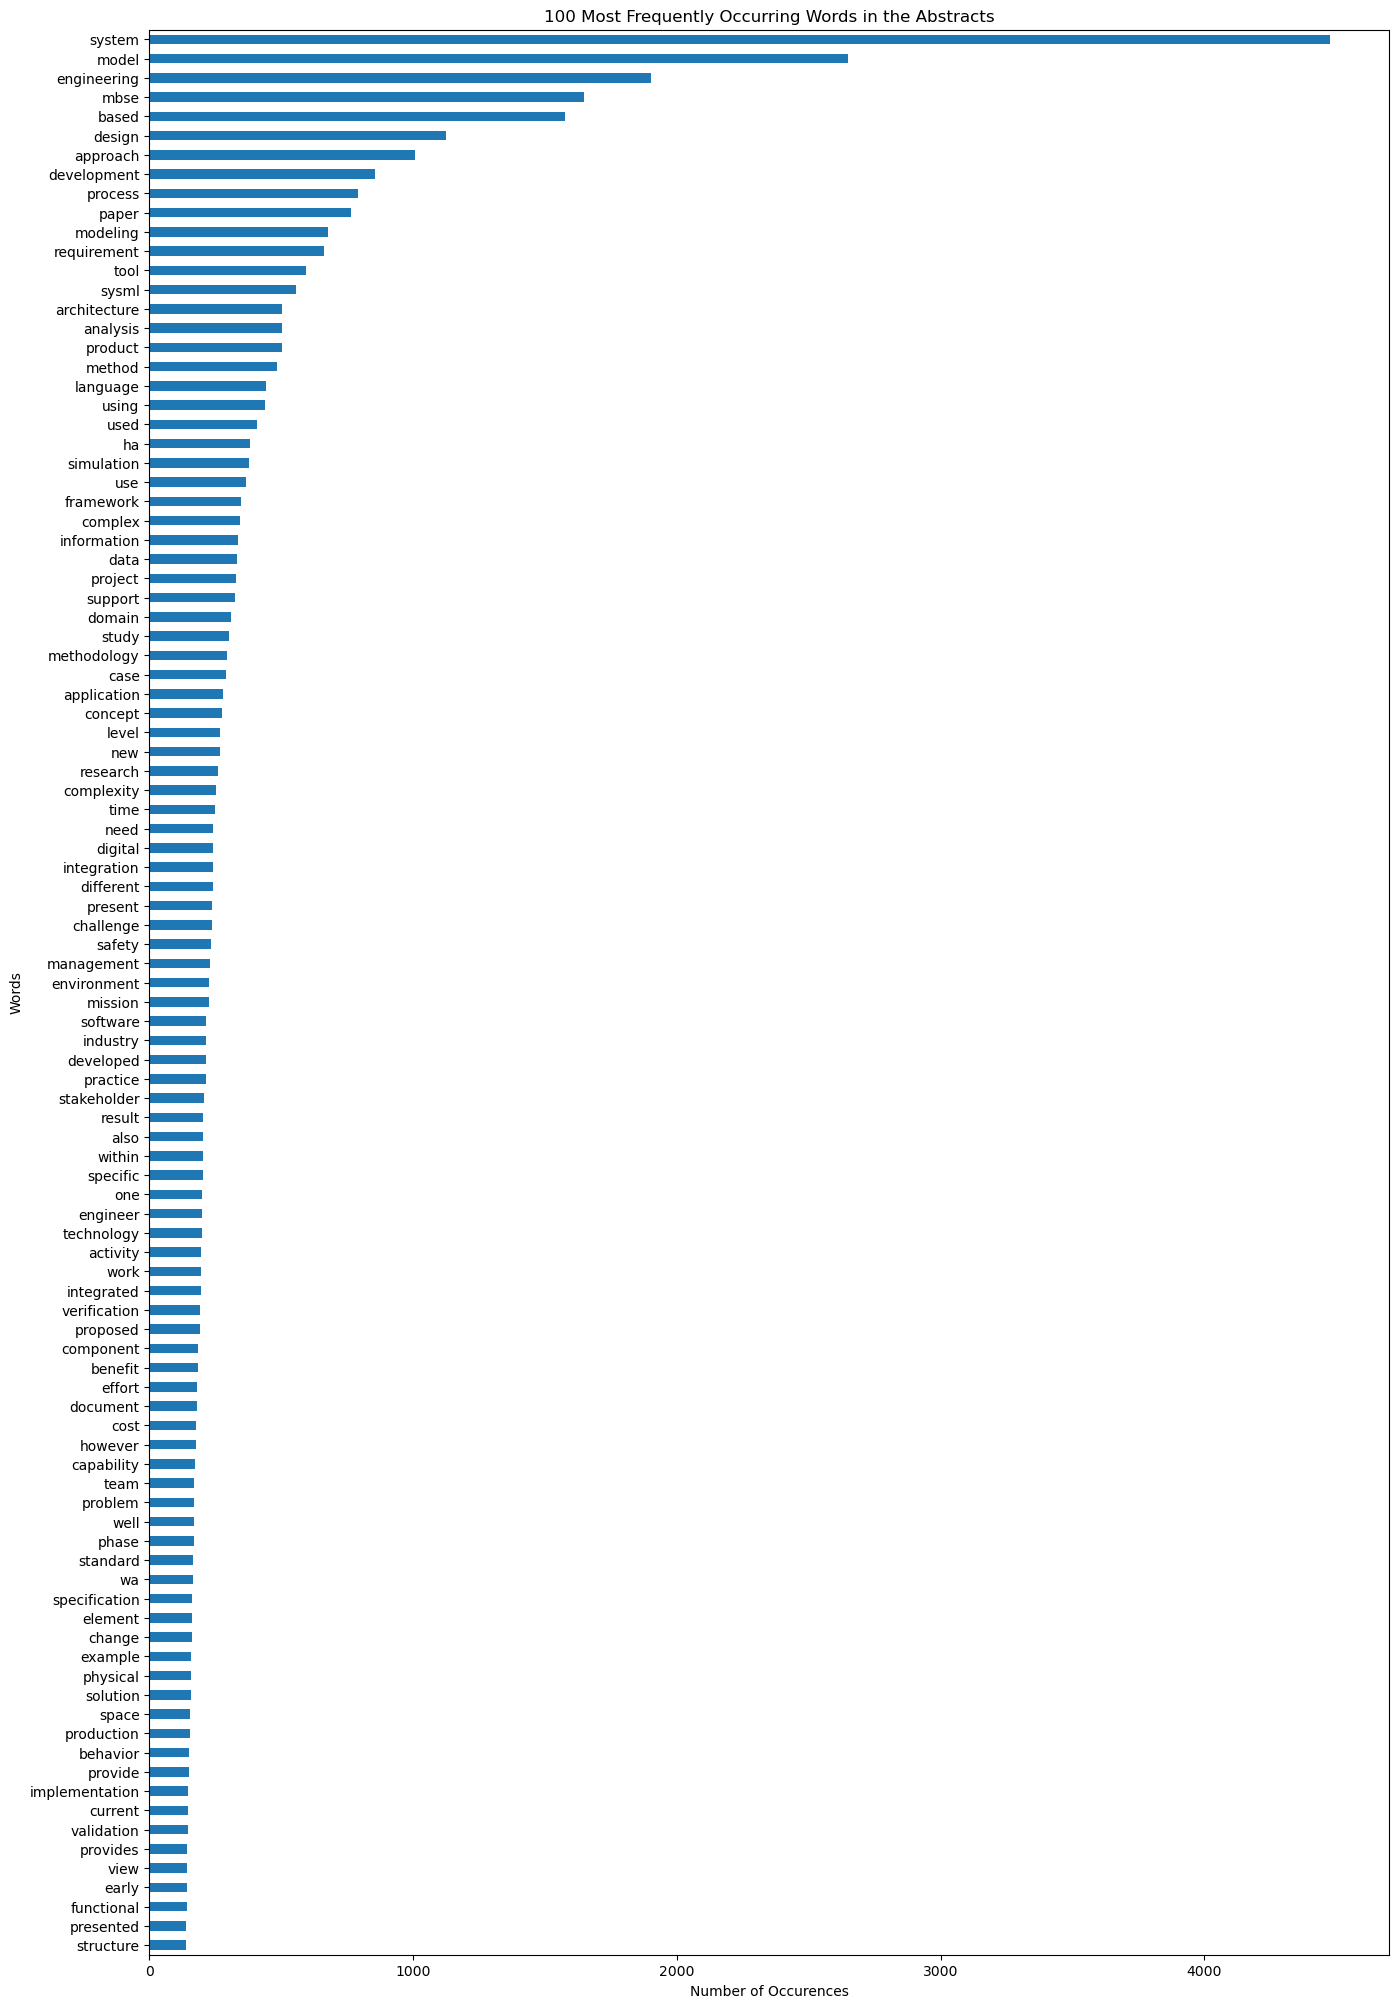

In [94]:
# Plot the 100 most frequently occuring unigrams in the abstracts
plt.figure(figsize=(16,25))
top_100_words = journals_unigrams.sum().sort_values(ascending=False).head(100)
top_100_words.sort_values(ascending=True).plot(kind='barh');
plt.title('100 Most Frequently Occurring Words in the Abstracts')
plt.ylabel('Words')
plt.xlabel('Number of Occurences');

From the above distribution, we can identify various words to add into our stopwords: $using, used, ha, use, also, within, however, well, wa, example$. <br>

Further to that, using domain knowledge, we'll remove the most frequently occuring words above that we know will appear in all journals. The words identified are: $system, model, engineering, design, based, mbse, approach, development, process, sysml, modeling, paper, product, architecture$

#### Remove the Additional Stopwords Identified Above

In [95]:
# Create list of high frequency words that are identified as stopwords
additional_stop_words = ['using', 'used', 'ha', 'use', 'also', 'within', 
                         'however', 'well', 'wa', 'example', 'system', 'model',
                         'engineering', 'design', 'based', 'mbse', 'approach',
                         'development', 'process', 'sysml', 'modeling', 'paper',
                         'product', 'architecture']

# Add the additional stop words to the original stop word list
stop_words.extend(additional_stop_words)

In [96]:
%%time
# Preprocess the data again
journals['tokens'] = journals['abstract'].apply(preprocess_text)

# Join the tokenized words so that we can vectorize them
journals['tokens'] = [" ".join(post) for post in journals['tokens']]

# Instantiate a CountVectorizer with ngrams 1 for word frequency analysis
cvec_journals_1 = CountVectorizer(lowercase=False, ngram_range=(1,1))

# Instantiate a CountVectorizer with ngrams 2 for bigram analysis
cvec_journals_2 = CountVectorizer(lowercase=False, ngram_range=(2,2))

# Instantiate a CountVectorizer with ngrams 3 for trigram analysis
cvec_journals_3 = CountVectorizer(lowercase=False, ngram_range=(3,3))


# Fit the three vectorizers, transform the data and export them into a dataframe

# Unigrams
cvec_journals_1.fit(journals['tokens'])
journals_unigrams = cvec_journals_1.transform(journals['tokens'])
journals_unigrams = pd.DataFrame(journals_unigrams.todense(), 
                                 columns=cvec_journals_1.get_feature_names_out())

# Bigrams
cvec_journals_2.fit(journals['tokens'])
journals_bigrams = cvec_journals_2.transform(journals['tokens'])
journals_bigrams = pd.DataFrame(journals_bigrams.todense(), 
                                 columns=cvec_journals_2.get_feature_names_out())

# Trigrams
cvec_journals_3.fit(journals['tokens'])
journals_trigrams = cvec_journals_3.transform(journals['tokens'])
journals_trigrams = pd.DataFrame(journals_trigrams.todense(), 
                                 columns=cvec_journals_3.get_feature_names_out())

CPU times: user 2.48 s, sys: 183 ms, total: 2.67 s
Wall time: 2.75 s


#### Word Frequency Analysis

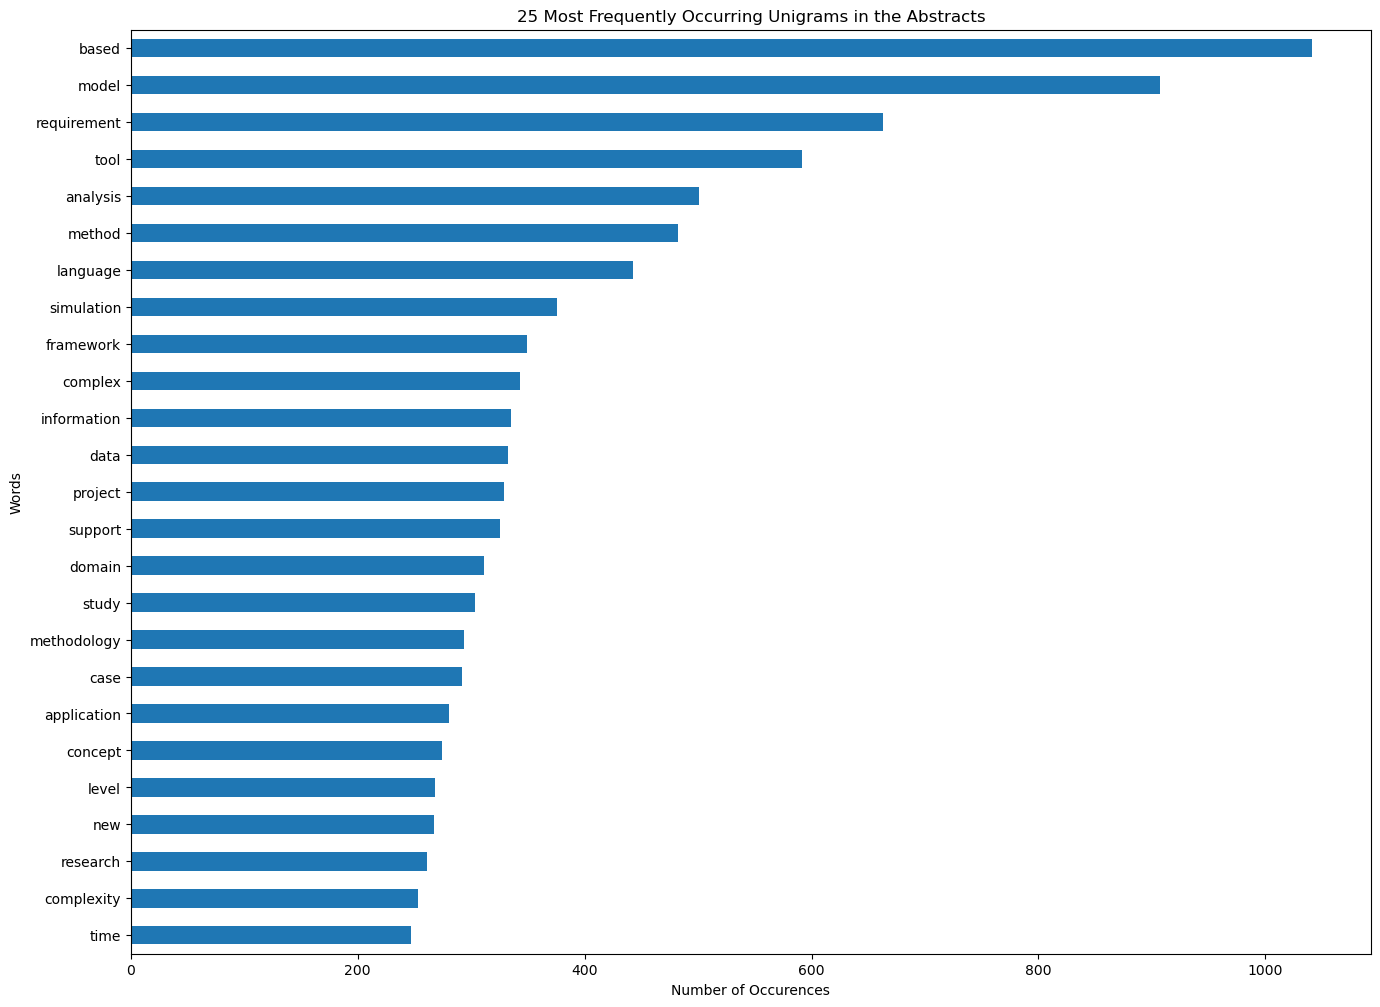

In [97]:
# Plot the 25 most frequently occuring unigrams in the abstracts
plt.figure(figsize=(16,12))
top_25_unigrams = journals_unigrams.sum().sort_values(ascending=False).head(25)
top_25_unigrams.sort_values(ascending=True).plot(kind='barh');
plt.title('25 Most Frequently Occurring Unigrams in the Abstracts')
plt.ylabel('Words')
plt.xlabel('Number of Occurences');

In [98]:
top_25_unigrams

based          1041
model           907
requirement     663
tool            592
analysis        501
method          482
language        443
simulation      376
framework       349
complex         343
information     335
data            332
project         329
support         325
domain          311
study           303
methodology     294
case            292
application     280
concept         274
level           268
new             267
research        261
complexity      253
time            247
dtype: int64

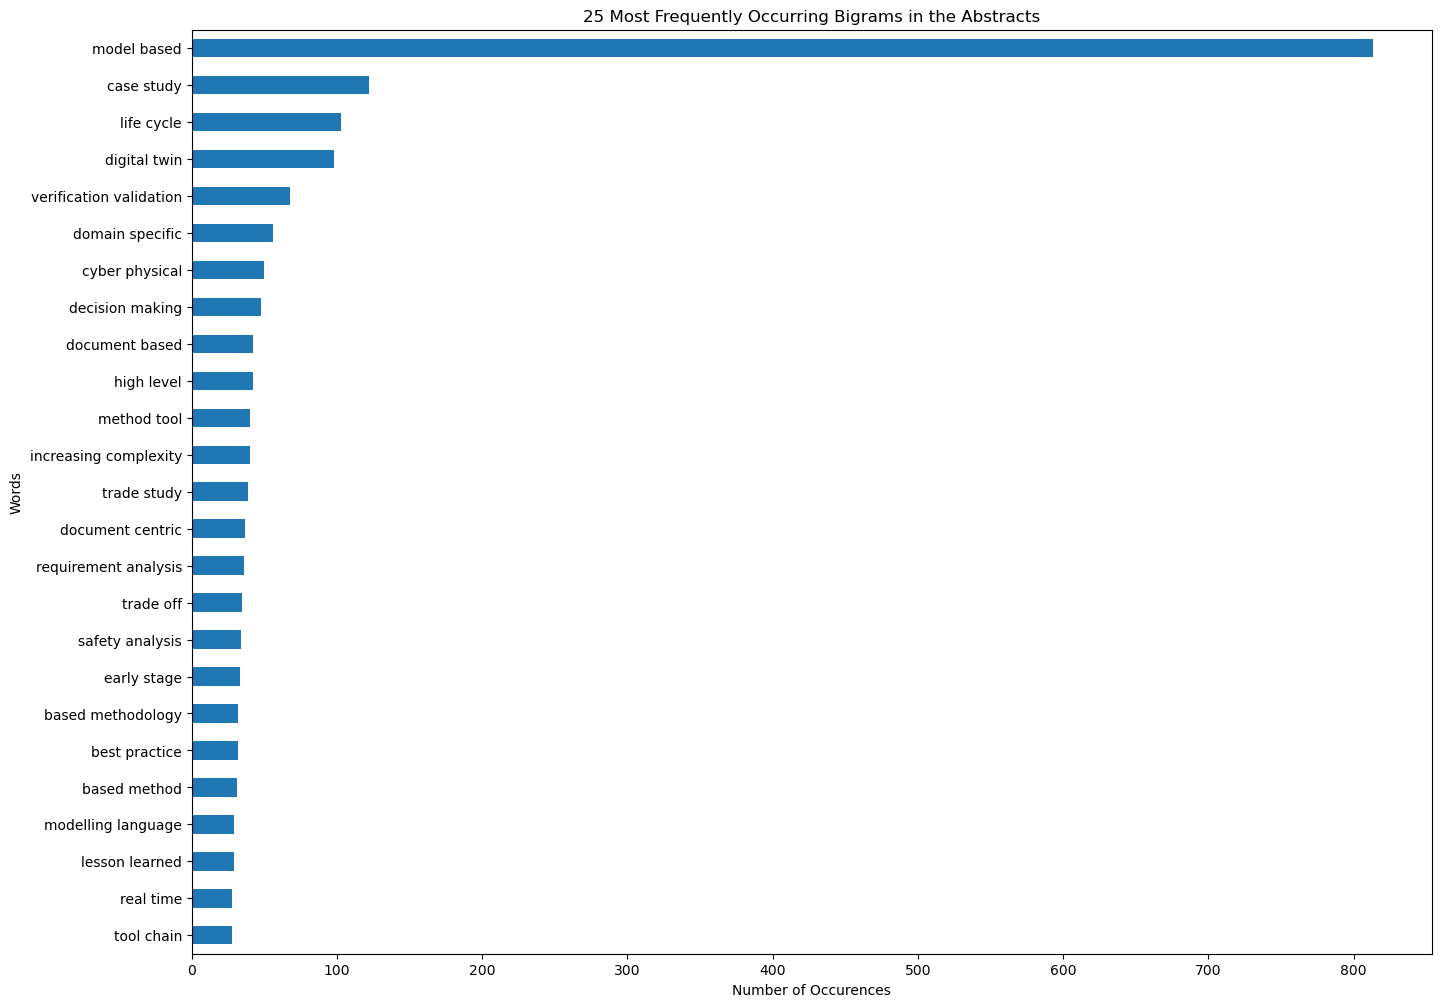

In [99]:
# Plot the 25 most frequently occuring bigrams in the abstracts
plt.figure(figsize=(16,12))
top_25_bigrams = journals_bigrams.sum().sort_values(ascending=False).head(25)
top_25_bigrams.sort_values(ascending=True).plot(kind='barh');
plt.title('25 Most Frequently Occurring Bigrams in the Abstracts')
plt.ylabel('Words')
plt.xlabel('Number of Occurences');

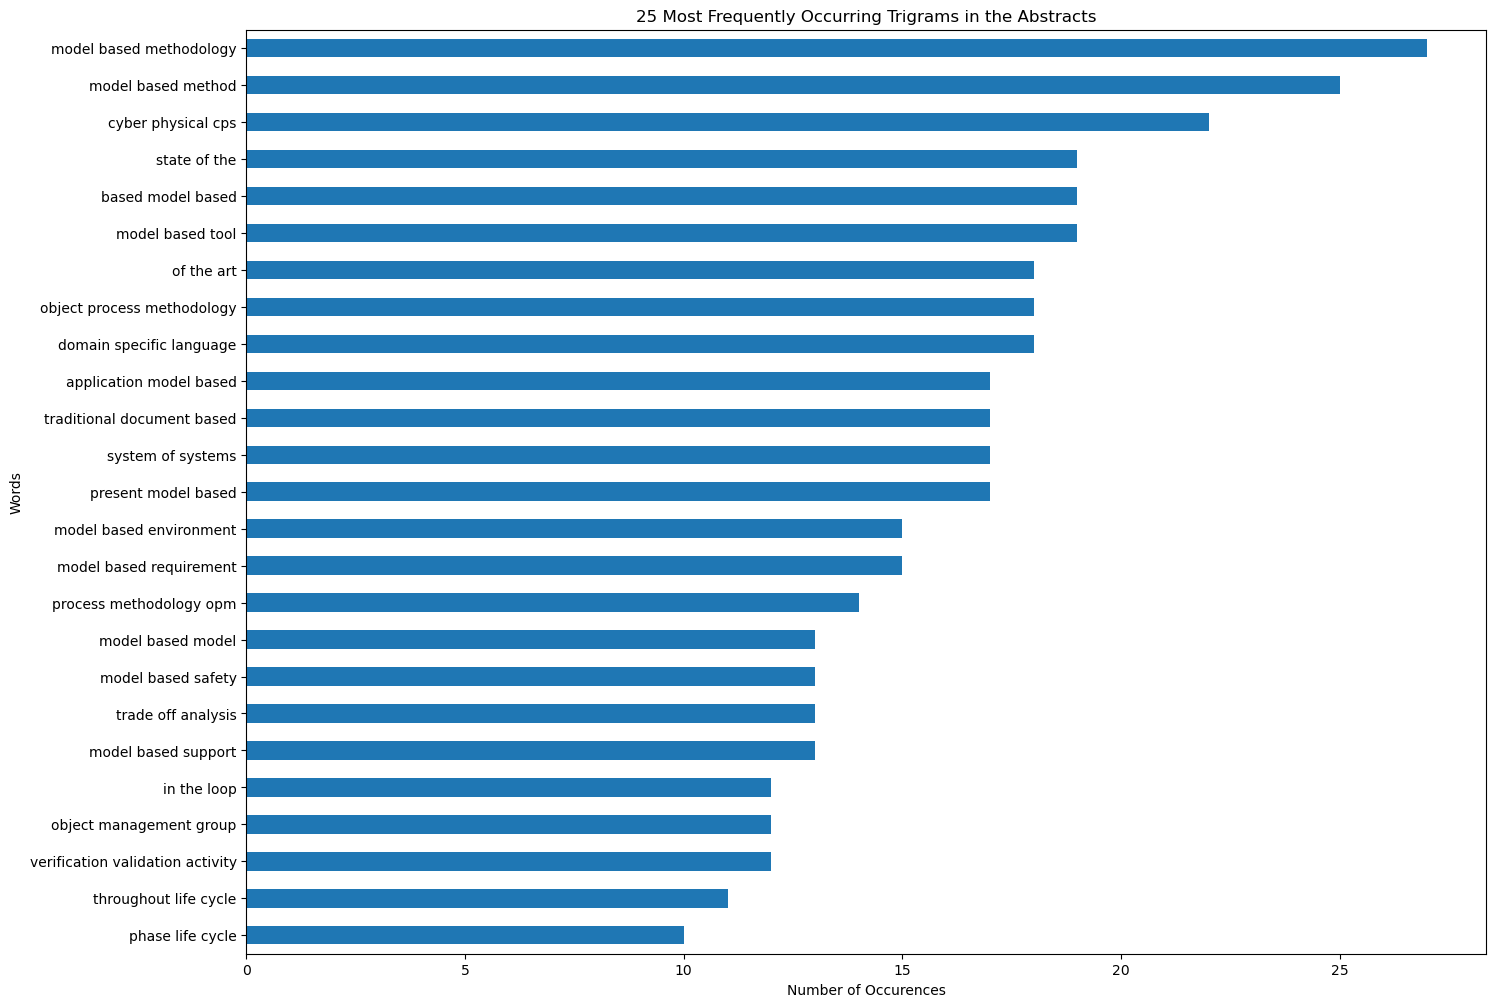

In [100]:
# Plot the 25 most frequently occuring trigrams in the abstracts
plt.figure(figsize=(16,12))
top_25_trigrams = journals_trigrams.sum().sort_values(ascending=False).head(25)
top_25_trigrams.sort_values(ascending=True).plot(kind='barh');
plt.title('25 Most Frequently Occurring Trigrams in the Abstracts')
plt.ylabel('Words')
plt.xlabel('Number of Occurences');

#### Word Clouds of the Unigrams, Bigrams and Trigrams

In [101]:
# Count the frequencies of the words in the Unigrams, Bigrams and Trigrams
unigrams_count = journals_unigrams.sum().sort_values(ascending=False)
bigrams_count = journals_bigrams.sum().sort_values(ascending=False)
trigrams_count = journals_trigrams.sum().sort_values(ascending=False)

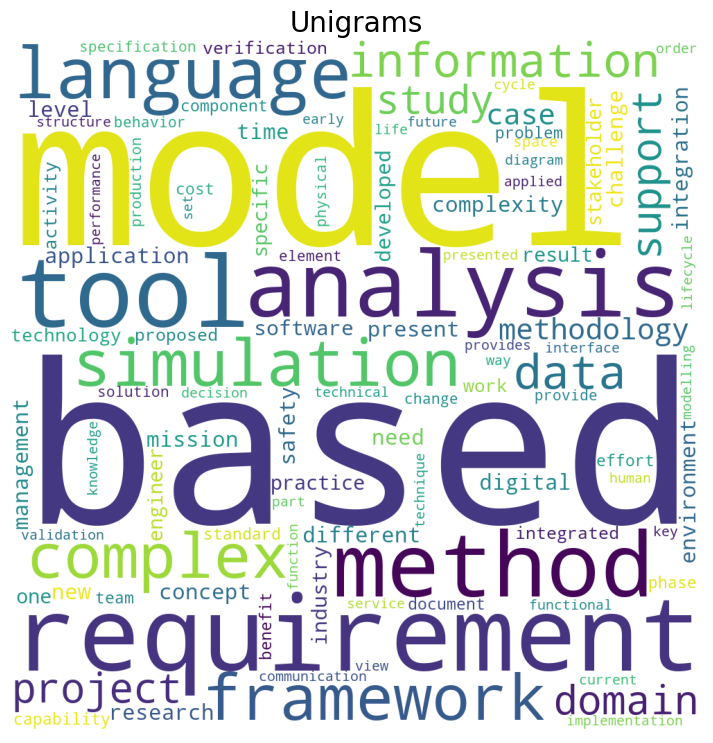

In [102]:
# Create a word cloud for the unigrams
wordcloud_unigrams = WordCloud(max_words=100, width=1000, height=1000, 
                             background_color='white').generate_from_frequencies(unigrams_count)

plt.figure(figsize=(16,9))
plt.imshow(wordcloud_unigrams)
plt.axis('off')
plt.title('Unigrams', fontsize=20);

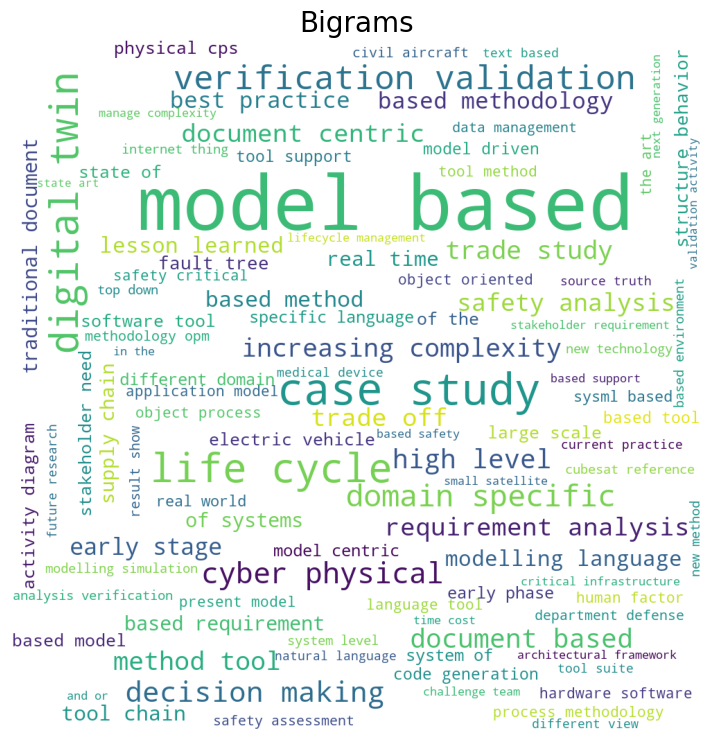

In [103]:
# Create a word cloud for the bigrams
wordcloud_bigrams = WordCloud(max_words=100, width=1000, height=1000, 
                             background_color='white').generate_from_frequencies(bigrams_count)

plt.figure(figsize=(16,9))
plt.imshow(wordcloud_bigrams)
plt.axis('off')
plt.title('Bigrams', fontsize=20);

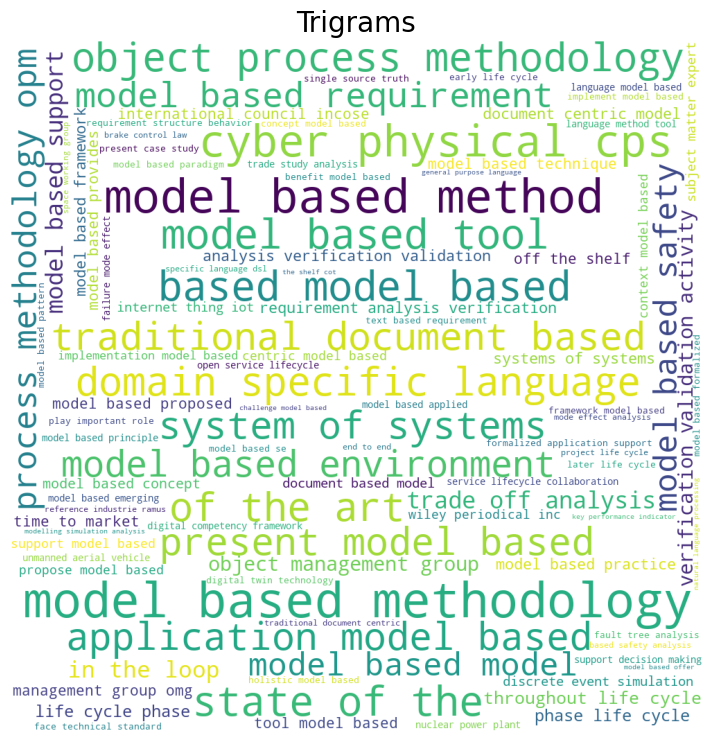

In [104]:
# Create a word cloud for the trigrams
wordcloud_trigrams = WordCloud(max_words=100, width=1000, height=1000, 
                             background_color='white').generate_from_frequencies(trigrams_count)

plt.figure(figsize=(16,9))
plt.imshow(wordcloud_trigrams)
plt.axis('off')
plt.title('Trigrams', fontsize=20);

## Export the Data

Now that we have completed the data processing, let's export the data into another notebook to perform topic modelling.

In [105]:
journals.to_csv('../data/journals_processed.csv', index=False)